## **Import Library**

In [2]:
# Library untuk analisis dan manipulasi data
import pandas as pd
import numpy as np

# Library untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Library untuk pemrosesan teks (Content-Based Filtering)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Library Sastrawi untuk pemrosesan teks Bahasa Indonesia
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Library untuk Collaborative Filtering dengan Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Library untuk utilitas lain dan display tabel
from IPython.display import display # Untuk menampilkan DataFrame dengan border
import pickle # Untuk menyimpan model/objek Python
import os # Untuk operasi sistem seperti membuat direktori
import warnings
warnings.filterwarnings('ignore') # Mengabaikan pesan warning untuk output lebih bersih
print("Semua library yang dibutuhkan telah di-import.")


Semua library yang dibutuhkan telah di-import.


## **Definisi Fungsi dan Kelas**

### Inisialisasi Variabel Global

In [3]:
# Variabel untuk menyimpan hasil dan status model
results = {}
MODEL_CF_SUCCESS = False
MODEL_CBF_SUCCESS = False

# DataFrame untuk menyimpan hasil rekomendasi
top_5_recs_cbf = pd.DataFrame()
top_5_recs_cf_keras = pd.DataFrame()

print("Variabel global telah diinisialisasi.")

Variabel global telah diinisialisasi.


### Fungsi untuk Preprocessing Teks (Sastrawi)

In [4]:
def preprocess_text_sastrawi(text, stemmer, stopword_remover):
    if pd.isna(text) or text.strip() == '': return ''
    text = text.lower()
    text_stemmed = stemmer.stem(text)
    text_cleaned = stopword_remover.remove(text_stemmed)
    return text_cleaned

print("Fungsi untuk Pricessing telah berhasil didefinisikan")

Fungsi untuk Pricessing telah berhasil didefinisikan


### Kelas Model Collaborative Filtering (RecommenderNet)

In [5]:
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_places, embedding_size=50, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.user_embedding = layers.Embedding(num_users, embedding_size, embeddings_initializer='he_normal', embeddings_regularizer=keras.regularizers.l2(1e-6))
        self.user_bias = layers.Embedding(num_users, 1)
        self.place_embedding = layers.Embedding(num_places, embedding_size, embeddings_initializer='he_normal', embeddings_regularizer=keras.regularizers.l2(1e-6))
        self.place_bias = layers.Embedding(num_places, 1)
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias_vec = self.user_bias(inputs[:, 0])
        place_vector = self.place_embedding(inputs[:, 1])
        place_bias_vec = self.place_bias(inputs[:, 1])
        dot_user_place = tf.tensordot(user_vector, place_vector, 2)
        x = dot_user_place + user_bias_vec + place_bias_vec
        return tf.nn.sigmoid(x)

print("Kelas RecommenderNet telah berhasil didefinisikan")

Kelas RecommenderNet telah berhasil didefinisikan


### Fungsi untuk Mendapatkan Rekomendasi

In [6]:
def get_content_based_recommendations(place_id_ref, n=5, cosine_sim_matrix_param=None, tourism_df_param=None, id_to_idx_map_param=None):
    if cosine_sim_matrix_param is None or tourism_df_param is None or id_to_idx_map_param is None:
        return "Model CBF belum siap."
    if place_id_ref not in id_to_idx_map_param:
        place_name_matches = tourism_df_param[tourism_df_param['Place_Name'] == place_id_ref]
        if not place_name_matches.empty:
            place_id_ref_from_name = place_name_matches['Place_Id'].iloc[0]
            if place_id_ref_from_name in id_to_idx_map_param: idx = id_to_idx_map_param[place_id_ref_from_name]
            else: return f"ID Tempat (dari nama) '{place_id_ref_from_name}' tidak ditemukan di map."
        else: return f"ID Tempat atau Nama '{place_id_ref}' tidak ditemukan."
    else: idx = id_to_idx_map_param[place_id_ref]    
    sim_scores = list(enumerate(cosine_sim_matrix_param[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:n+1]
    place_indices = [i[0] for i in sim_scores]
    recommendations_df = tourism_df_param.iloc[place_indices][['Place_Id', 'Place_Name', 'Category', 'Rating']].copy()
    recommendations_df['similarity_score'] = [s[1] for s in sim_scores]
    return recommendations_df

def get_top_n_recommendations_keras_cf(user_real_id, n=5, model=None, tourism_df_all_yogya=None, rating_df_yogya_cf=None, mappings=None):
    if model is None or mappings is None:
        return "Model CF belum siap."
    user_to_user_encoded_cf = mappings['user_to_user_encoded']
    place_to_place_encoded_cf = mappings['place_to_place_encoded']
    place_encoded_to_place_cf = mappings['place_encoded_to_place']
    
    user_enc = user_to_user_encoded_cf.get(user_real_id)
    if user_enc is None: return "User ID tidak ditemukan dalam data training CF."
    all_place_ids_yogya = tourism_df_all_yogya['Place_Id'].unique()
    place_ids_in_cf_model_list = list(place_to_place_encoded_cf.keys())
    rated_items_by_user = rating_df_yogya_cf[rating_df_yogya_cf['User_Id'] == user_real_id]['Place_Id'].unique()
    candidate_items_for_prediction = [pid for pid in all_place_ids_yogya if pid in place_ids_in_cf_model_list and pid not in rated_items_by_user]
    if not candidate_items_for_prediction: return pd.DataFrame(columns=['Place_Id', 'Place_Name', 'Category', 'Rating', 'Predicted_Normalized_Rating'])
    place_encoded_candidates = [place_to_place_encoded_cf[pid] for pid in candidate_items_for_prediction]
    user_place_array = np.array([[user_enc, place_enc] for place_enc in place_encoded_candidates])
    predictions_normalized = model.predict(user_place_array, verbose=0).flatten()
    top_indices = predictions_normalized.argsort()[-n:][::-1]
    recommended_original_place_ids = [place_encoded_to_place_cf[place_encoded_candidates[i]] for i in top_indices]
    recommendations_df = tourism_df_all_yogya[tourism_df_all_yogya['Place_Id'].isin(recommended_original_place_ids)][['Place_Id', 'Place_Name', 'Category', 'Rating']].copy()
    pred_map = {place_encoded_to_place_cf[place_encoded_candidates[i]]: predictions_normalized[i] for i in top_indices}
    recommendations_df['Predicted_Normalized_Rating'] = recommendations_df['Place_Id'].map(pred_map)
    return recommendations_df.sort_values('Predicted_Normalized_Rating', ascending=False)

print("Fungsi untuk Mendapatkan Rekomendasi telah berhasil didefinisikan.")


Fungsi untuk Mendapatkan Rekomendasi telah berhasil didefinisikan.


## **Data Understanding**

### Memuat Dataset

In [7]:
# Memuat Dataset
df_tourism_raw = pd.read_csv('dataset/tourism_with_id.csv')
df_rating_raw = pd.read_csv('dataset/tourism_rating.csv')
df_user_raw = pd.read_csv('dataset/user.csv')
print("\nFile CSV berhasil dimuat dari folder 'dataset/'.")


File CSV berhasil dimuat dari folder 'dataset/'.


### Membuat Salinan

In [8]:
# Membuat salinan untuk diproses agar data mentah tetap ada jika diperlukan
df_tourism = df_tourism_raw.copy()
df_rating = df_rating_raw.copy()
df_user = df_user_raw.copy()
print("\nDataFrame berhasil dicopy untuk mengantisipasi data oroginal masih tersimpan rapi.")


DataFrame berhasil dicopy untuk mengantisipasi data oroginal masih tersimpan rapi.


### Informasi Umum dan Variabel Dataset

#### `df_tourism` (Tempat Wisata)

In [9]:
print("Info Detail Variabel (df_tourism):")
df_tourism.info()

print("Contoh Data Awal (df_tourism):")
display(df_tourism.head(3))

print("Contoh Data Akhir (df_tourism):")
display(df_tourism.tail(3))

print("\nStatistik Deskriptif Harga (Price) dan Rating Publik (Rating) pada df_tourism:")
display(df_tourism[['Price', 'Rating']].describe())

print("\nCek nilai null di df_tourism:")
display(df_tourism.isnull().sum().to_frame(name='jumlah_null'))

Info Detail Variabel (df_tourism):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 44.5+ KB
Contoh Data Awal (df_tourism):


,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3


Contoh Data Akhir (df_tourism):


,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
434,435,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...,Taman Hiburan,Surabaya,0,4.4,45.0,"{'lat': -7.2752955, 'lng': 112.7549381}",-7.275296,112.754938,NaN,435
435,436,Taman Flora Bratang Surabaya,Taman Flora adalah salah satu taman kota di Su...,Taman Hiburan,Surabaya,0,4.6,NaN,"{'lat': -7.294330299999999, 'lng': 112.7617534}",-7.294330,112.761753,NaN,436
436,437,Gereja Perawan Maria Tak Berdosa Surabaya,Gereja Katolik Kelahiran Santa Perawan Maria m...,Tempat Ibadah,Surabaya,10000,4.8,NaN,"{'lat': -7.2420758, 'lng': 112.7368158}",-7.242076,112.736816,NaN,437



Statistik Deskriptif Harga (Price) dan Rating Publik (Rating) pada df_tourism:


,Price,Rating
count,437.000000,437.000000
mean,24652.173913,4.442792
std,66446.374709,0.208587
min,0.000000,3.400000
25%,0.000000,4.300000
50%,5000.000000,4.500000
75%,20000.000000,4.600000
max,900000.000000,5.000000



Cek nilai null di df_tourism:


,jumlah_null
Place_Id,0
Place_Name,0
Description,0
Category,0
City,0
Price,0
Rating,0
Time_Minutes,232
Coordinate,0
Lat,0


#### `df_rating` (Rating Pengguna)

In [10]:
print("Info Detail Variabel (df_rating):")
df_rating.info()

print("Contoh Data Awal (df_rating):")
display(df_rating.head(3))

print("Contoh Data Akhir (df_rating):")
display(df_rating.tail(3))

print("\nStatistik Deskriptif Rating Pengguna (Place_Ratings) pada df_rating:")
display(df_rating['Place_Ratings'].describe().to_frame(name='statistik_place_ratings'))

print("\nCek nilai null di df_rating:")
display(df_rating.isnull().sum().to_frame(name='jumlah_null'))

Info Detail Variabel (df_rating):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB
Contoh Data Awal (df_rating):


,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5


Contoh Data Akhir (df_rating):


,User_Id,Place_Id,Place_Ratings
9997,300,311,3
9998,300,279,4
9999,300,163,2



Statistik Deskriptif Rating Pengguna (Place_Ratings) pada df_rating:


,statistik_place_ratings
count,10000.000000
mean,3.066500
std,1.379952
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000



Cek nilai null di df_rating:


,jumlah_null
User_Id,0
Place_Id,0
Place_Ratings,0


#### `df_user` (Pengguna)

In [11]:
print("Info Detail Variabel (df_user):")
df_user.info()

print("Contoh Data Awal (df_user):")
display(df_user.head(3))

print("Contoh Data Akhir (df_user):")
display(df_user.tail(3))

print("\nStatistik Deskriptif Usia (Age) pada df_user:")
display(df_user['Age'].describe().to_frame(name='statistik_usia'))

print("\nCek nilai null di df_user:")
display(df_user.isnull().sum().to_frame(name='jumlah_null'))

Info Detail Variabel (df_user):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User_Id   300 non-null    int64 
 1   Location  300 non-null    object
 2   Age       300 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.2+ KB
Contoh Data Awal (df_user):


,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23


Contoh Data Akhir (df_user):


,User_Id,Location,Age
297,298,"Bogor, Jawa Barat",38
298,299,"Sragen, Jawa Tengah",27
299,300,"Ponorogo, Jawa Timur",26



Statistik Deskriptif Usia (Age) pada df_user:


,statistik_usia
count,300.000000
mean,28.700000
std,6.393716
min,18.000000
25%,24.000000
50%,29.000000
75%,34.000000
max,40.000000



Cek nilai null di df_user:


,jumlah_null
User_Id,0
Location,0
Age,0


## **Univariate Exploratory Data Analysis (EDA)**

### Distribusi Sebaran Rating Pengguna

Rating,Jumlah
1,1706
2,2071
3,2096
4,2106
5,2021


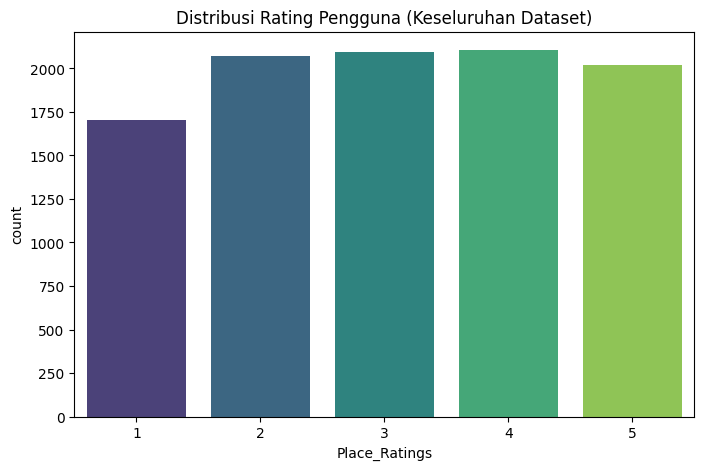

Insight: Visualisasi menunjukkan rating yang paling sering diberikan oleh pengguna adalah 4.


In [12]:
most_frequent_rating = df_rating['Place_Ratings'].mode()[0]
rating_counts = df_rating['Place_Ratings'].value_counts().reset_index()
rating_counts.columns = ['Rating', 'Jumlah']
display(rating_counts.sort_values(by='Rating').style.hide(axis="index"))
plt.figure(figsize=(8, 5))
sns.countplot(x='Place_Ratings', data=df_rating, palette='viridis', order=sorted(df_rating['Place_Ratings'].unique()))
plt.title('Distribusi Rating Pengguna (Keseluruhan Dataset)')
plt.show()
print(f"Insight: Visualisasi menunjukkan rating yang paling sering diberikan oleh pengguna adalah {most_frequent_rating}.")

### Distribusi Sebaran Destinasi Berdasarkan Kota

Kota,Jumlah Tempat Wisata
Yogyakarta,126
Bandung,124
Jakarta,84
Semarang,57
Surabaya,46


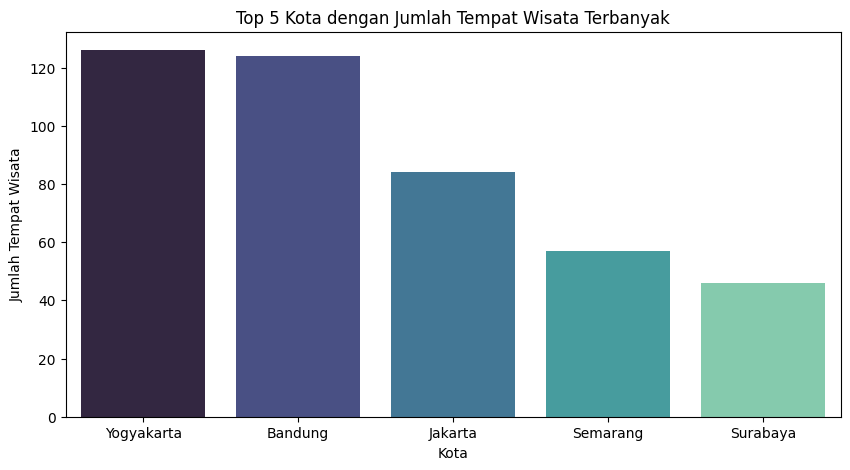

Insight: Berdasarkan data, 5 kota dengan destinasi wisata terbanyak adalah ['Yogyakarta', 'Bandung', 'Jakarta', 'Semarang', 'Surabaya']. Ini menegaskan bahwa fokus dataset adalah pada pusat-pusat pariwisata utama di Indonesia, dengan Yogyakarta memiliki jumlah terbanyak yaitu 126 destinasi.


In [13]:
top_cities = df_tourism['City'].value_counts().nlargest(5).reset_index()
top_cities.columns = ['Kota', 'Jumlah Tempat Wisata']
display(top_cities.style.hide(axis="index"))
plt.figure(figsize=(10, 5))
sns.barplot(x='Kota', y='Jumlah Tempat Wisata', data=top_cities, palette='mako')
plt.title('Top 5 Kota dengan Jumlah Tempat Wisata Terbanyak')
plt.show()
print(f"Insight: Berdasarkan data, 5 kota dengan destinasi wisata terbanyak adalah {top_cities['Kota'].tolist()}. Ini menegaskan bahwa fokus dataset adalah pada pusat-pusat pariwisata utama di Indonesia, dengan {top_cities['Kota'].iloc[0]} memiliki jumlah terbanyak yaitu {top_cities['Jumlah Tempat Wisata'].iloc[0]} destinasi.")


### Distribusi Sebaran Destinasi Berdasarkan Kategori

Kategori,Jumlah Tempat Wisata
Taman Hiburan,135
Budaya,117
Cagar Alam,106
Bahari,47
Tempat Ibadah,17


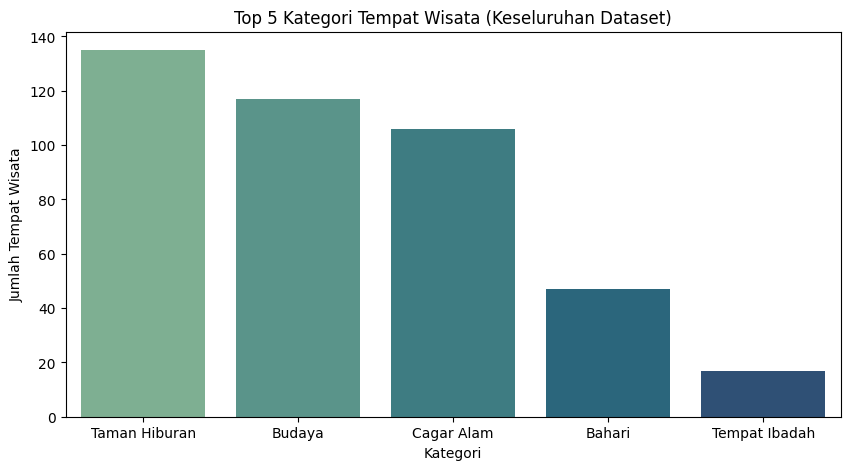

Insight: Kategori wisata paling populer di seluruh dataset adalah 'Taman Hiburan' dengan jumlah 135 tempat.


In [14]:
top_categories_all = df_tourism['Category'].value_counts().nlargest(5).reset_index()
top_categories_all.columns = ['Kategori', 'Jumlah Tempat Wisata']
display(top_categories_all.style.hide(axis="index"))
plt.figure(figsize=(10, 5))
sns.barplot(x='Kategori', y='Jumlah Tempat Wisata', data=top_categories_all, palette='crest')
plt.title('Top 5 Kategori Tempat Wisata (Keseluruhan Dataset)')
plt.show()
print(f"Insight: Kategori wisata paling populer di seluruh dataset adalah '{top_categories_all['Kategori'].iloc[0]}' dengan jumlah {top_categories_all['Jumlah Tempat Wisata'].iloc[0]} tempat.")


### Distribusi Sebaran Usia Pengguna

Usia,Jumlah Pengguna
18,15
19,12
20,16
21,13
22,7
23,11
24,13
25,15
26,9
27,17


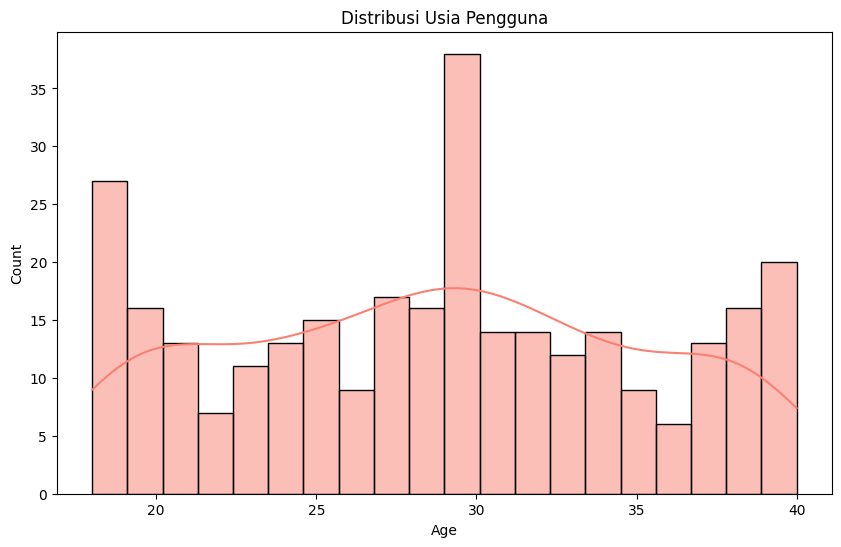

Insight: Distribusi usia pengguna menunjukkan konsentrasi yang kuat antara usia 24 hingga 34 tahun, dengan median usia di sekitar 29 tahun.


In [15]:
age_counts = df_user['Age'].value_counts().reset_index()
age_counts.columns = ['Usia', 'Jumlah Pengguna']
display(age_counts.sort_values(by='Usia').style.hide(axis="index"))
age_stats = df_user['Age'].describe()
age_median = int(age_stats['50%'])
age_q1 = int(age_stats['25%'])
age_q3 = int(age_stats['75%'])
plt.figure(figsize=(10, 6))
sns.histplot(data=df_user, x='Age', bins=20, kde=True, color='salmon')
plt.title('Distribusi Usia Pengguna')
plt.show()
print(f"Insight: Distribusi usia pengguna menunjukkan konsentrasi yang kuat antara usia {age_q1} hingga {age_q3} tahun, dengan median usia di sekitar {age_median} tahun.")

## **Data Preprocessing**

### Pegecekan dam Penanganan Nilai Duplikat

In [16]:
# Penanganan duplikat untuk df_tourism
jumlah_data_awal_tourism = len(df_tourism)
jumlah_duplikat_tourism = df_tourism.duplicated().sum()
print(f"df_tourism - Jumlah data awal: {jumlah_data_awal_tourism}")
print(f"df_tourism - Jumlah data duplikat ditemukan: {jumlah_duplikat_tourism}")
df_tourism.drop_duplicates(inplace=True)
print(f"df_tourism - Jumlah data setelah hapus duplikat: {len(df_tourism)}")

# Penanganan duplikat untuk df_rating
jumlah_data_awal_rating = len(df_rating)
jumlah_duplikat_rating = df_rating.duplicated().sum()
print(f"\ndf_rating - Jumlah data awal: {jumlah_data_awal_rating}")
print(f"df_rating - Jumlah data duplikat ditemukan: {jumlah_duplikat_rating}")
df_rating.drop_duplicates(inplace=True)
print(f"df_rating - Jumlah data setelah hapus duplikat: {len(df_rating)}")

# Penanganan duplikat untuk df_user berdasarkan User_Id
jumlah_data_awal_user = len(df_user)
jumlah_duplikat_user_id = df_user.duplicated(subset=['User_Id']).sum()
print(f"\ndf_user - Jumlah data awal: {jumlah_data_awal_user}")
print(f"df_user - Jumlah data duplikat ditemukan: {jumlah_duplikat_user_id}")
df_user.drop_duplicates(subset=['User_Id'], inplace=True, keep='first')
print(f"df_user - Jumlah data setelah hapus duplikat: {len(df_user)}")

print("Penanganan duplikat selesai.")

df_tourism - Jumlah data awal: 437
df_tourism - Jumlah data duplikat ditemukan: 0
df_tourism - Jumlah data setelah hapus duplikat: 437

df_rating - Jumlah data awal: 10000
df_rating - Jumlah data duplikat ditemukan: 79
df_rating - Jumlah data setelah hapus duplikat: 9921

df_user - Jumlah data awal: 300
df_user - Jumlah data duplikat ditemukan: 0
df_user - Jumlah data setelah hapus duplikat: 300
Penanganan duplikat selesai.


## **Data Preparation**

### Filtering Data untuk Yogyakarta

In [17]:
target_keyword = 'yogyakarta'
df_tourism_yogya = df_tourism[df_tourism['City'].str.contains(target_keyword, case=False, na=False)].copy()
if df_tourism_yogya.empty:
    print("Tidak ada destinasi Yogyakarta ditemukan. Program berhenti.")
    exit()
print(f"Jumlah destinasi di area Yogyakarta: {len(df_tourism_yogya)}")

Jumlah destinasi di area Yogyakarta: 126


### Membersihkan Data Rating Yogyakarta untuk Collaborative Filtering (CF)

In [18]:
place_ids_yogya = df_tourism_yogya['Place_Id'].unique()
df_rating_yogya_cf = df_rating[df_rating['Place_Id'].isin(place_ids_yogya)].copy()
df_rating_yogya_cf.dropna(subset=['Place_Ratings'], inplace=True)
df_rating_yogya_cf['Place_Ratings'] = pd.to_numeric(df_rating_yogya_cf['Place_Ratings'], errors='coerce')
df_rating_yogya_cf.dropna(subset=['Place_Ratings'], inplace=True)
print(f"Jumlah rating Yogyakarta untuk CF setelah cleaning: {len(df_rating_yogya_cf)}")

Jumlah rating Yogyakarta untuk CF setelah cleaning: 2848


### Rekayasa Fitur untuk Content-Based Filtering (CBF)

In [19]:
df_tourism_yogya['Rating'] = pd.to_numeric(df_tourism_yogya['Rating'], errors='coerce').fillna(df_tourism_yogya['Rating'].median())
print("Memproses teks menggunakan Sastrawi...")
stemmer = StemmerFactory().create_stemmer()
stopword_remover = StopWordRemoverFactory().create_stop_word_remover()
df_tourism_yogya['content_features'] = (df_tourism_yogya['Place_Name'].fillna('') + ' ' + 
                                        df_tourism_yogya['Category'].fillna('') + ' ' + 
                                        df_tourism_yogya['Description'].fillna('')).apply(lambda x: preprocess_text_sastrawi(x, stemmer, stopword_remover))
print("Kolom 'content_features' untuk CBF telah dibuat.")
display(df_tourism_yogya[['Place_Name', 'content_features']].head(2))

Memproses teks menggunakan Sastrawi...
Kolom 'content_features' untuk CBF telah dibuat.


,Place_Name,content_features
84,Taman Pintar Yogyakarta,taman pintar yogyakarta taman hibur taman pint...
85,Keraton Yogyakarta,keraton yogyakarta budaya keraton ngayogyakart...


## **Model Development Dengan Content Based Filtering (CBF)**

### Perhitungan TF-IDF dan Cosine Similarity

In [20]:
tfidf_vectorizer = TfidfVectorizer(min_df=1) 
tfidf_matrix_cbf = tfidf_vectorizer.fit_transform(df_tourism_yogya['content_features'])
cosine_sim_cbf = cosine_similarity(tfidf_matrix_cbf)
results['CBF_tfidf_matrix_shape'] = tfidf_matrix_cbf.shape
print(f"[CBF] Matriks TF-IDF berhasil dibuat dengan dimensi: {results['CBF_tfidf_matrix_shape']}")
MODEL_CBF_SUCCESS = True

[CBF] Matriks TF-IDF berhasil dibuat dengan dimensi: (126, 2151)


### Visualisasi Matriks Kesamaan (Cosine Similarity)

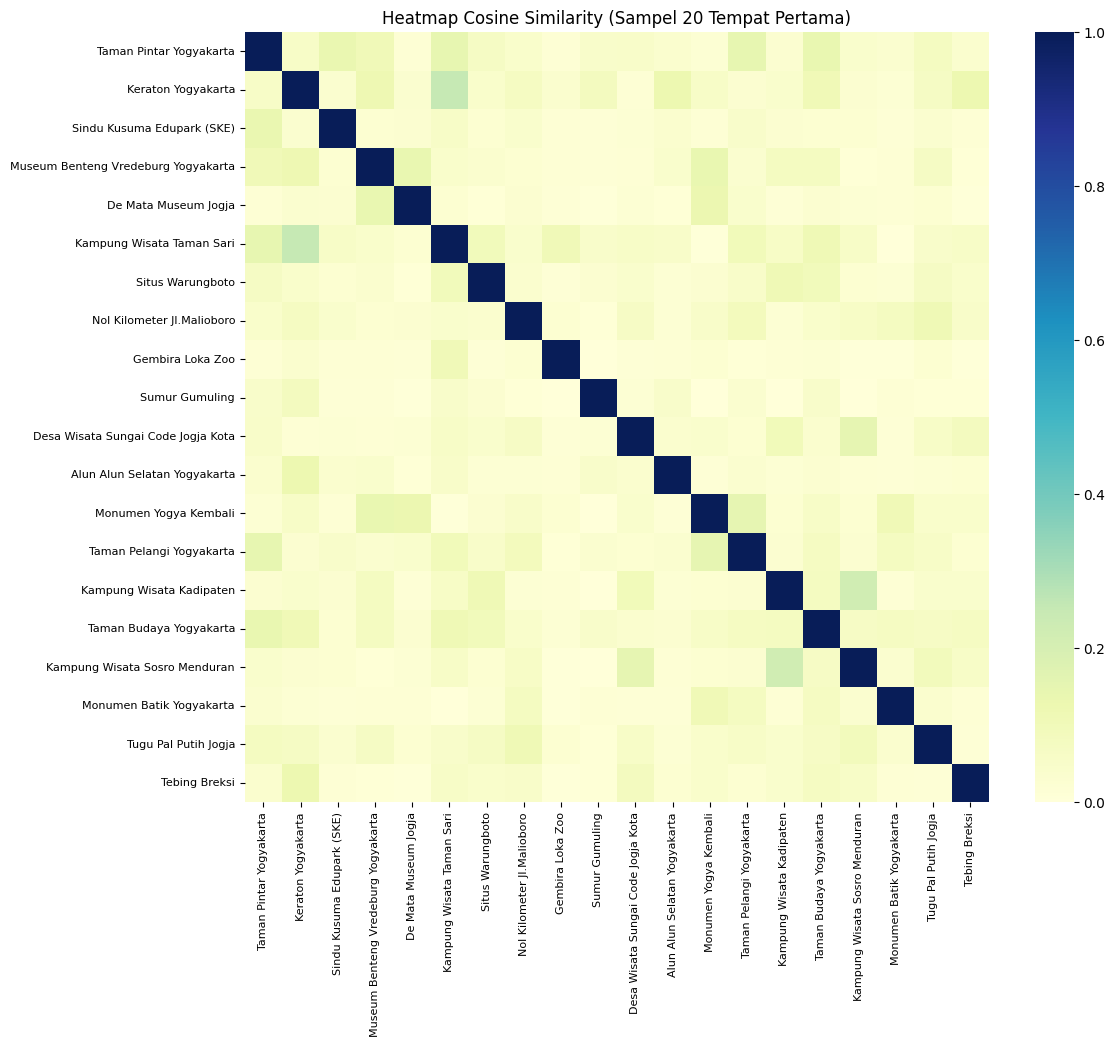

In [21]:
sample_size = 20
df_tourism_yogya_cbf_display = df_tourism_yogya.reset_index(drop=True)
sample_indices = df_tourism_yogya_cbf_display.head(sample_size).index
sample_cosine_sim = cosine_sim_cbf[sample_indices, :][:, sample_indices]
sample_place_names = df_tourism_yogya_cbf_display.head(sample_size)['Place_Name']
plt.figure(figsize=(12, 10))
sns.heatmap(sample_cosine_sim, annot=False, cmap='YlGnBu', xticklabels=sample_place_names, yticklabels=sample_place_names)
plt.title('Heatmap Cosine Similarity (Sampel 20 Tempat Pertama)')
plt.xticks(rotation=90, size=8); plt.yticks(size=8)
plt.show()

### Uji Coba Model CBF

In [22]:
placeid_to_idx_map_cbf = pd.Series(df_tourism_yogya_cbf_display.index, index=df_tourism_yogya_cbf_display['Place_Id'])
sample_place_id_cbf = df_tourism_yogya_cbf_display['Place_Id'].iloc[0]
sample_place_name_cbf = df_tourism_yogya_cbf_display.loc[df_tourism_yogya_cbf_display['Place_Id'] == sample_place_id_cbf, 'Place_Name'].iloc[0]
results['CBF_sample_place_name'] = sample_place_name_cbf
print(f"[CBF] Contoh Top-5 Rekomendasi berdasarkan kemiripan dengan '{sample_place_name_cbf}':")
top_5_recs_cbf = get_content_based_recommendations(sample_place_id_cbf, cosine_sim_matrix_param=cosine_sim_cbf, tourism_df_param=df_tourism_yogya_cbf_display, id_to_idx_map_param=placeid_to_idx_map_cbf)
results['CBF_example_recommendations'] = top_5_recs_cbf
display(top_5_recs_cbf.style.hide(axis="index"))

[CBF] Contoh Top-5 Rekomendasi berdasarkan kemiripan dengan 'Taman Pintar Yogyakarta':


Place_Id,Place_Name,Category,Rating,similarity_score
206,Wisata Kaliurang,Cagar Alam,4.400000,0.192158
98,Taman Pelangi Yogyakarta,Taman Hiburan,4.300000,0.148100
90,Kampung Wisata Taman Sari,Taman Hiburan,4.600000,0.147447
203,Galaxy Waterpark Jogja,Taman Hiburan,4.300000,0.147205
100,Taman Budaya Yogyakarta,Budaya,4.500000,0.140009


## **Model Development Dengan Collaborative Filtering (CF)**

### Persiapan Data untuk Model CF

In [23]:
# Cek apakah data rating Yogyakarta ada untuk memulai
if not df_rating_yogya_cf.empty and df_rating_yogya_cf['User_Id'].nunique() > 1 and df_rating_yogya_cf['Place_Id'].nunique() > 1:
    print("Memulai persiapan data: Encoding User_Id dan Place_Id, normalisasi rating, dan split data...")
    
    # Encoding User_Id dan Place_Id
    user_ids_cf = df_rating_yogya_cf['User_Id'].unique().tolist()
    user_to_user_encoded_cf = {x: i for i, x in enumerate(user_ids_cf)}
    user_encoded_to_user_cf = {i: x for i, x in enumerate(user_ids_cf)}
    df_rating_yogya_cf['user_encoded'] = df_rating_yogya_cf['User_Id'].map(user_to_user_encoded_cf)

    place_ids_cf_model = df_rating_yogya_cf['Place_Id'].unique().tolist()
    place_to_place_encoded_cf = {x: i for i, x in enumerate(place_ids_cf_model)}
    place_encoded_to_place_cf = {i: x for i, x in enumerate(place_ids_cf_model)}
    df_rating_yogya_cf['place_encoded'] = df_rating_yogya_cf['Place_Id'].map(place_to_place_encoded_cf)

    num_users_cf = len(user_to_user_encoded_cf)
    num_places_cf_model = len(place_to_place_encoded_cf)
    
    # Normalisasi rating
    min_rating_cf = df_rating_yogya_cf['Place_Ratings'].min()
    max_rating_cf = df_rating_yogya_cf['Place_Ratings'].max()
    if max_rating_cf > min_rating_cf:
        df_rating_yogya_cf['rating_normalized'] = df_rating_yogya_cf['Place_Ratings'].apply(lambda x: (x - min_rating_cf) / (max_rating_cf - min_rating_cf)).values
    else:
        df_rating_yogya_cf['rating_normalized'] = 0.5
    
    # Mengacak dan membagi data
    df_cf_shuffled = df_rating_yogya_cf.sample(frac=1, random_state=42)
    x_cf = df_cf_shuffled[['user_encoded', 'place_encoded']].values
    y_cf = df_cf_shuffled['rating_normalized'].values
    
    train_indices_cf = int(0.8 * df_cf_shuffled.shape[0])
    x_train_cf, x_val_cf, y_train_cf, y_val_cf = (
        x_cf[:train_indices_cf],
        x_cf[train_indices_cf:],
        y_cf[:train_indices_cf],
        y_cf[train_indices_cf:]
    )
    
    validation_data_keras = (x_val_cf, y_val_cf)
    print("Persiapan Data CF Selesai.")
    print("Pembagian Data:")
    print(f"Data Train   : {len(x_train_cf)}")
    print(f"Data Validasi: {len(x_val_cf)}")
    MODEL_CF_PREPARED = True
else:
    print("Data rating Yogyakarta tidak cukup untuk memulai Collaborative Filtering.")
    MODEL_CF_PREPARED = False

Memulai persiapan data: Encoding User_Id dan Place_Id, normalisasi rating, dan split data...
Persiapan Data CF Selesai.
Pembagian Data:
Data Train   : 2278
Data Validasi: 570


### Training Model CF

In [24]:
if MODEL_CF_PREPARED:
    # Mendefinisikan arsitektur model (RecommenderNet)
    # Fungsi dan kelas sudah didefinisikan di CELL 2
    model_keras_cf = RecommenderNet(num_users_cf, num_places_cf_model, embedding_size=50)
    
    # Kompilasi model
    model_keras_cf.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    
    # Melatih model
    print("Melatih model Keras RecommenderNet...")
    history_cf = model_keras_cf.fit(
        x=x_train_cf, 
        y=y_train_cf,
        batch_size=64, 
        epochs=100,
        validation_data=validation_data_keras,
        verbose=1
    )
    
    MODEL_CF_SUCCESS = True
    results['CF_history'] = history_cf.history
    print("Training Model CF Selesai.")
else:
    print("Model CF tidak dilatih karena persiapan data gagal atau data tidak memadai.")

Melatih model Keras RecommenderNet...
Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.7390 - root_mean_squared_error: 0.3778 - val_loss: 0.7194 - val_root_mean_squared_error: 0.3637
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7288 - root_mean_squared_error: 0.3717 - val_loss: 0.7192 - val_root_mean_squared_error: 0.3636
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7158 - root_mean_squared_error: 0.3646 - val_loss: 0.7182 - val_root_mean_squared_error: 0.3630
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7292 - root_mean_squared_error: 0.3707 - val_loss: 0.7143 - val_root_mean_squared_error: 0.3605
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7510 - root_mean_squared_error: 0.3807 - val_loss: 0.7110 - val_root_mean_squared_error: 0.3582
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7165 - root_mean_squared_error: 0.3637 - val_loss: 0.7162 - val_root_mean_squared_error: 0.3616
Epoch 7/100
36/36 ━

### Uji Coba Model CF

In [25]:
if MODEL_CF_SUCCESS:
    # Menggabungkan semua mapping yang dibutuhkan oleh fungsi rekomendasi
    cf_mappings = {
        'user_to_user_encoded': user_to_user_encoded_cf,
        'place_to_place_encoded': place_to_place_encoded_cf,
        'place_encoded_to_place': place_encoded_to_place_cf
    }
    
    # Mengambil sampel user untuk pengujian
    sample_user_id_cf_keras = df_rating_yogya_cf['User_Id'].unique()[0]
    results['CF_Keras_sample_user_id'] = sample_user_id_cf_keras
    print(f"[CF Keras] Contoh Top-5 Rekomendasi untuk User ID: {sample_user_id_cf_keras}")
    
    # Memanggil fungsi untuk mendapatkan rekomendasi
    top_5_recs_cf_keras = get_top_n_recommendations_keras_cf(
        user_real_id=sample_user_id_cf_keras, 
        model=model_keras_cf, 
        tourism_df_all_yogya=df_tourism_yogya, 
        rating_df_yogya_cf=df_rating_yogya_cf, 
        mappings=cf_mappings
    )
    results['CF_Keras_example_recommendations'] = top_5_recs_cf_keras
    
    # Menampilkan hasil
    if isinstance(top_5_recs_cf_keras, pd.DataFrame) and not top_5_recs_cf_keras.empty:
        display(top_5_recs_cf_keras.style.hide(axis="index"))
    else:
        print(f"Tidak ada rekomendasi baru untuk User ID {sample_user_id_cf_keras}.")
else:
    print("Uji Coba Model CF tidak dapat dilakukan karena model tidak berhasil dilatih.")

[CF Keras] Contoh Top-5 Rekomendasi untuk User ID: 1


Place_Id,Place_Name,Category,Rating,Predicted_Normalized_Rating
139,Puncak Gunung Api Purba - Nglanggeran,Cagar Alam,4.700000,0.769608
138,Jogja Exotarium,Taman Hiburan,4.400000,0.730769
132,Air Terjun Kedung Pedut,Cagar Alam,4.500000,0.723506
134,Desa Wisata Gamplong,Taman Hiburan,4.400000,0.712936
136,Grojogan Watu Purbo Bangunrejo,Taman Hiburan,4.500000,0.710067


## **Evaluation**

### Evaluasi Model Collaborative Filtering

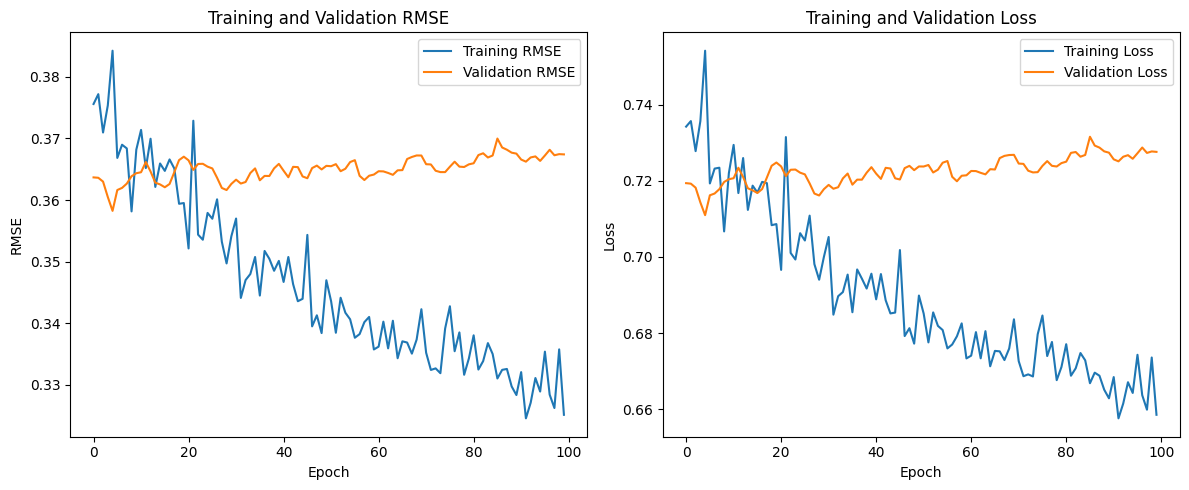

  Metrik Evaluasi (Final Validation RMSE): 0.3674


In [26]:
if MODEL_CF_SUCCESS:
    history_data = results.get('CF_history', {})
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history_data.get('root_mean_squared_error', []), label='Training RMSE')
    plt.plot(history_data.get('val_root_mean_squared_error', []), label='Validation RMSE')
    plt.title('Training and Validation RMSE'); plt.xlabel('Epoch'); plt.ylabel('RMSE'); plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history_data.get('loss', []), label='Training Loss')
    plt.plot(history_data.get('val_loss', []), label='Validation Loss')
    plt.title('Training and Validation Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
    plt.tight_layout()
    plt.show()
    final_val_rmse = history_data.get('val_root_mean_squared_error', [None])[-1]
    results['CF_Keras_Val_RMSE'] = final_val_rmse
    print(f"  Metrik Evaluasi (Final Validation RMSE): {final_val_rmse:.4f}" if final_val_rmse else "N/A")
else:
    print("  Model CF (Keras) tidak dievaluasi.")

### Evaluasi Model Content-Based Filtering

  Evaluasi Kualitatif: Model ini dievaluasi secara kualitatif berdasarkan relevansi item yang direkomendasikan.
  Dimensi Matriks TF-IDF: (126, 2151)

  Visualisasi Similarity Score untuk rekomendasi 'Taman Pintar Yogyakarta':


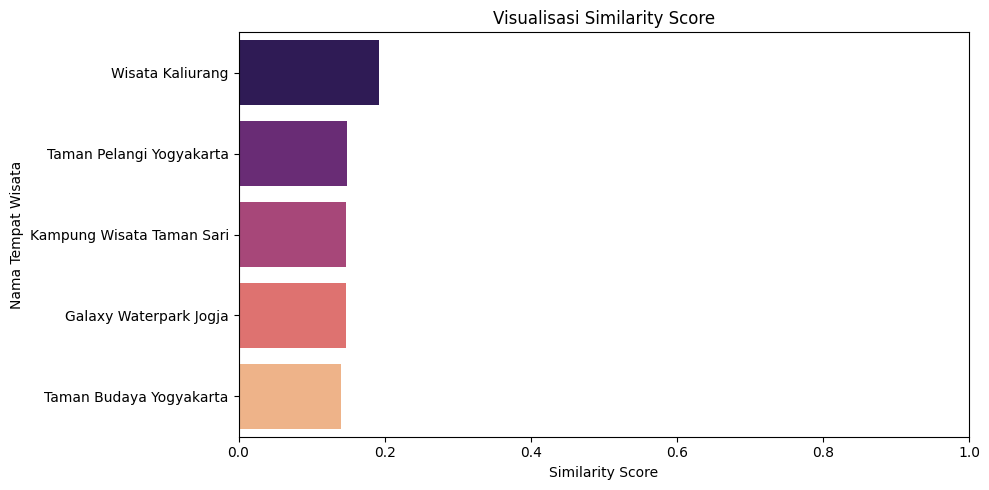

In [27]:
if MODEL_CBF_SUCCESS:
    print(f"  Evaluasi Kualitatif: Model ini dievaluasi secara kualitatif berdasarkan relevansi item yang direkomendasikan.")
    print(f"  Dimensi Matriks TF-IDF: {results.get('CBF_tfidf_matrix_shape', 'N/A')}")
    recs_cbf_df = results.get('CBF_example_recommendations', pd.DataFrame())
    if isinstance(recs_cbf_df, pd.DataFrame) and not recs_cbf_df.empty:
        print(f"\n  Visualisasi Similarity Score untuk rekomendasi '{results.get('CBF_sample_place_name', 'N/A')}':")
        plt.figure(figsize=(10, 5))
        sns.barplot(x='similarity_score', y='Place_Name', data=recs_cbf_df, palette='magma')
        plt.title(f"Visualisasi Similarity Score"); plt.xlabel('Similarity Score'); plt.ylabel('Nama Tempat Wisata'); plt.xlim(0, 1)
        plt.tight_layout()
        plt.show()
    else: 
        print(f"  Contoh Rekomendasi CBF: Tidak ada atau gagal.")
else:
    print("  Model CBF tidak berhasil dilatih atau dievaluasi.")

## **Penyimpanan Model**

### Membuat folder `saved_model`

In [28]:
save_dir = 'saved_model'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Folder '{save_dir}' berhasil dibuat.")

Folder 'saved_model' berhasil dibuat.


### Menyimpan Model Content-Based Filtering

In [29]:
if MODEL_CBF_SUCCESS:
    print("Menyimpan Model Content-Based Filtering ---")
    pickle.dump(tfidf_vectorizer, open(os.path.join(save_dir, 'cbf_tfidf_vectorizer.pkl'), 'wb'))
    np.save(os.path.join(save_dir, 'cbf_cosine_similarity_matrix.npy'), cosine_sim_cbf)
    df_tourism_yogya_cbf_display.to_csv(os.path.join(save_dir, 'cbf_tourism_data.csv'), index=False)
    print(f"Artefak CBF berhasil disimpan di folder '{save_dir}'.")
else:
    print("Model CBF tidak berhasil, tidak ada yang disimpan.")

Menyimpan Model Content-Based Filtering ---
Artefak CBF berhasil disimpan di folder 'saved_model'.


### Menyimpan Model Collaborative Filtering

In [30]:
if MODEL_CF_SUCCESS:
    print("Menyimpan Model Collaborative Filtering ---")
    # Menambahkan ekstensi .keras pada nama file sesuai rekomendasi TensorFlow
    model_keras_cf.save(os.path.join(save_dir, 'cf_recommender_keras_model.keras'))
    cf_mappings = {'user_to_user_encoded': user_to_user_encoded_cf, 'place_to_place_encoded': place_to_place_encoded_cf, 'place_encoded_to_place': place_encoded_to_place_cf}
    with open(os.path.join(save_dir, 'cf_mappings.pkl'), 'wb') as f:
        pickle.dump(cf_mappings, f)
    print(f"Model CF (Keras) dan data mapping berhasil disimpan di folder '{save_dir}'.")
else:
    print("Model CF tidak berhasil, tidak ada yang disimpan.")

Menyimpan Model Collaborative Filtering ---
Model CF (Keras) dan data mapping berhasil disimpan di folder 'saved_model'.
